# <center>Unsupervised learning: PCA and Clustering
 
In this lesson, we will work with unsupervised learning methods such as Principal Component Analysis (PCA) and clustering. You will learn why and how we can reduce the dimensionality of the original data and what the main approaches are for grouping similar data points.  


### Article outline
1. [Introduction](#1.-Introduction)
2. [PCA](#2.-Principal-Component-Analysis-(PCA))
 - [Intuition, theories, and application issues](#Intuition,-theories,-and-application-issues)
 - [Examples](#Examples)
3. [Clustering](#3.-Clustering)
 - [K-means](#K-means)
 - [Affinity Propagation](#Affinity-Propagation)
    - [Affinity Propagation - Example](#An-example-of-Affinity-Propagation)
 - [Spectral clustering](#Spectral-clustering)
    - [Spectral Clustring - Example](#An-example-of-Spectral-Clustring)
 - [Agglomerative clustering](#Agglomerative-clustering)
 - [Accuracy metrics](#Accuracy-metrics)
4. [Demo assignment](#4.-Demo-assignment)
5. [Useful resources](#5.-Useful-resources)

## 1. Introduction

The main feature of unsupervised learning algorithms, when compared to classification and regression methods, is that input data are unlabeled (i.e. no labels or classes given) and that the algorithm learns the structure of the data without any assistance. This creates two main differences. First, it allows us to process large amounts of data because the data does not need to be manually labeled. Second, it is difficult to evaluate the quality of an unsupervised algorithm due to the absence of an explicit goodness metric as used in supervised learning.  

One of the most common tasks in unsupervised learning is dimensionality reduction. On one hand, dimensionality reduction may help with data visualization (e.g. t-SNA method) while, on the other hand, it may help deal with the multicollinearity of your data and prepare the data for a supervised learning method (e.g. decision trees).


## 2. Principal Component Analysis (PCA)

### Intuition, theories, and application issues

Principal Component Analysis is one of the easiest, most intuitive, and most frequently used methods for dimensionality reduction, projecting data onto its orthogonal feature subspace.


<img align="right" src="https://habrastorage.org/getpro/habr/post_images/bb6/fe7/f06/bb6fe7f06e114bcc9c354a1cb025b966.png" width="400">


More generally speaking, all observations can be considered as an ellipsoid in a subspace of an initial feature space, and the new basis set in this subspace is aligned with the ellipsoid axes. This assumption lets us remove highly correlated features since basis set vectors are orthogonal. 
In the general case, the resulting ellipsoid dimensionality matches the initial space dimensionality, but the assumption that our data lies in a subspace with a smaller dimension allows us to cut off the "excessive" space with the new projection (subspace). We accomplish this in a 'greedy' fashion, sequentially selecting each of the ellipsoid axes by identifying where the dispersion is maximal.
 

> "To deal with hyper-planes in a 14 dimensional space, visualize a 3D space and say 'fourteen' very loudly. Everyone does it." - Geoffrey Hinton


Let's take a look at the mathematical formulation of this process:

In order to decrease the dimensionality of our data from $n$ to $k$ with $k \leq n$, we sort our list of axes in order of decreasing dispersion and take the top-$k$ of them.

We begin by computing the dispersion and the covariance of the initial features. This is usually done with the covariance matrix. According to the covariance definition, the covariance of two features is computed as follows: $$cov(X_i, X_j) = E[(X_i - \mu_i) (X_j - \mu_j)] = E[X_i X_j] - \mu_i \mu_j,$$ where $\mu_i$ is the expected value of the $i$th feature. It is worth noting that the covariance is symmetric, and the covariance of a vector with itself is equal to its dispersion.

Therefore the covariance matrix is symmetric with the dispersion of the corresponding features on the diagonal. Non-diagonal values are the covariances of the corresponding pair of features. In terms of matrices where $\mathbf{X}$ is the matrix of observations, the covariance matrix is as follows:

$$\Sigma = E[(\mathbf{X} - E[\mathbf{X}]) (\mathbf{X} - E[\mathbf{X}])^{T}]$$

Quick recap: matrices, as linear operators, have eigenvalues and eigenvectors. They are very convenient because they describe parts of our space that do not rotate and only stretch when we apply linear operators on them; eigenvectors remain in the same direction but are stretched by a corresponding eigenvalue. Formally, a matrix $M$ with eigenvector $w_i$ and eigenvalue $\lambda_i$ satisfy this equation: $M w_i = \lambda_i w_i$.

The covariance matrix for a sample $\mathbf{X}$ can be written as a product of $\mathbf{X}^{T} \mathbf{X}$. According to the [Rayleigh quotient](https://en.wikipedia.org/wiki/Rayleigh_quotient), the maximum variation of our sample lies along the eigenvector of this matrix and is consistent with the maximum eigenvalue. Therefore, the principal components we aim to retain from the data are just the eigenvectors corresponding to the top-$k$ largest eigenvalues of the matrix.

The next steps are easier to digest. We multiply the matrix of our data $X$ by these components to get the projection of our data onto the orthogonal basis of the chosen components. If the number of components was smaller than the initial space dimensionality, remember that we will lose some information upon applying this transformation.

## Examples
### Fisher's iris dataset

Let's start by uploading all of the essential modules and try out the iris example from the `scikit-learn` documentation. 

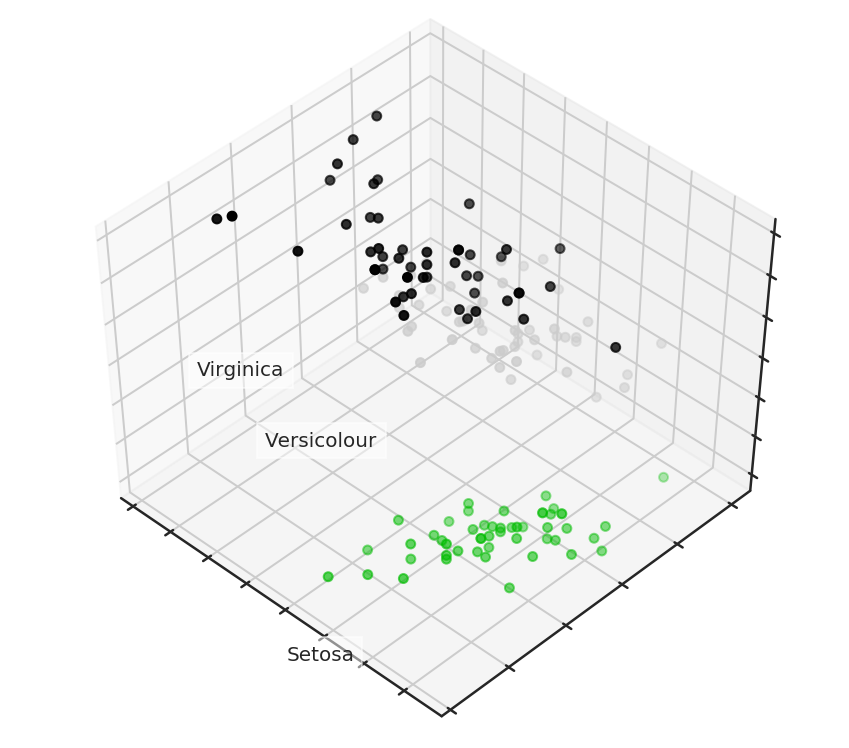

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='white')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from sklearn import decomposition
from sklearn import datasets
from mpl_toolkits.mplot3d import Axes3D

# Loading the dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Let's create a beautiful 3d-plot
fig = plt.figure(1, figsize=(6, 5))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()

for name, label in [('Setosa', 0), ('Versicolour', 1), ('Virginica', 2)]:
    ax.text3D(X[y == label, 0].mean(),
              X[y == label, 1].mean() + 1.5,
              X[y == label, 2].mean(), name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
    
# Change the order of labels, so that they match
y_clr = np.choose(y, [1, 2, 0]).astype(np.float)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y_clr, 
           cmap=plt.cm.nipy_spectral)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([]);

Now let's see how PCA will improve the results of a simple model that is not able to correctly fit all of the training data:

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# Train, test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=42)

# Decision trees with depth = 2
clf = DecisionTreeClassifier(max_depth=2, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, 
                                                preds.argmax(axis=1))))

Accuracy: 0.88889


Let's try this again, but, this time, let's reduce the dimensionality to 2 dimensions:

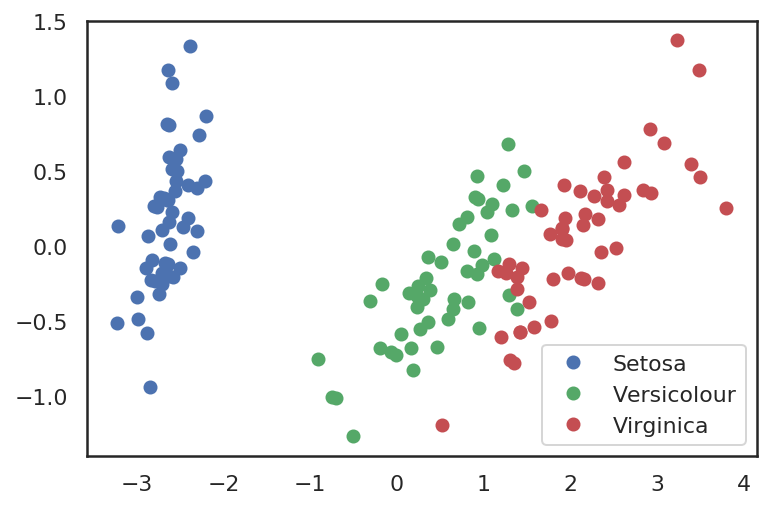

In [3]:
# Using PCA from sklearn PCA
pca = decomposition.PCA(n_components=2)
X_centered = X - X.mean(axis=0)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)

# Plotting the results of PCA
plt.plot(X_pca[y == 0, 0], X_pca[y == 0, 1], 'bo', label='Setosa')
plt.plot(X_pca[y == 1, 0], X_pca[y == 1, 1], 'go', label='Versicolour')
plt.plot(X_pca[y == 2, 0], X_pca[y == 2, 1], 'ro', label='Virginica')
plt.legend(loc=0);

In [4]:
# Test-train split and apply PCA
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=42)

clf = DecisionTreeClassifier(max_depth=2, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, 
                                                preds.argmax(axis=1))))

Accuracy: 0.91111


The accuracy did not increase significantly in this case, but, with other datasets with a high number of dimensions, PCA can drastically improve the accuracy of decision trees and other ensemble methods.

Now let's check out the percent of variance that can be explained by each of the selected components.

In [5]:
for i, component in enumerate(pca.components_):
    print("{} component: {}% of initial variance".format(i + 1, 
          round(100 * pca.explained_variance_ratio_[i], 2)))
    print(" + ".join("%.3f x %s" % (value, name)
                     for value, name in zip(component,
                                            iris.feature_names)))

1 component: 92.46% of initial variance
0.361 x sepal length (cm) + -0.085 x sepal width (cm) + 0.857 x petal length (cm) + 0.358 x petal width (cm)
2 component: 5.31% of initial variance
0.657 x sepal length (cm) + 0.730 x sepal width (cm) + -0.173 x petal length (cm) + -0.075 x petal width (cm)


__Component 1:__
- This component explains 92.46% of the initial variance in the data.
- The loadings indicate the contribution of each original feature to this component. For instance:
    - Sepal length (0.361), Sepal width (-0.085), Petal length (0.857), and Petal width (0.358).
- The signs of the coefficients (positive or negative) show the direction of the relationship between the original features and the principal component.

__Component 2:__
- This component explains 5.31% of the initial variance in the data.
- Similar to Component 1, it has its own set of loadings indicating the contribution of each original feature to this component.

The "explainability" in this context refers to how well each principal component explains the variance present in the original dataset. In PCA, components are ordered by the amount of variance they explain, with the first component explaining the most variance, followed by the second, and so on. By examining the explained variance ratios, you can understand how much information each component retains from the original dataset.

In this case, Component 1 captures the majority of the variance in the Iris dataset (92.46%), while Component 2 captures a smaller portion (5.31%). Together, these components provide a compact representation of the dataset while retaining most of its information, which can be useful for various analytical tasks and for visualizing the data in lower dimensions.

### Handwritten numbers dataset 

Let's look at the handwritten numbers dataset that we used before in the [3rd lesson](https://habrahabr.ru/company/ods/blog/322534/#derevya-resheniy-i-metod-blizhayshih-sosedey-v-zadache-raspoznavaniya-rukopisnyh-cifr-mnist).

In [6]:
digits = datasets.load_digits()
X = digits.data
y = digits.target

Let's start by visualizing our data. Fetch the first 10 numbers. The numbers are represented by 8 x 8 matrixes with the color intensity for each pixel. Every matrix is flattened into a vector of 64 numbers, so we get the feature version of the data.

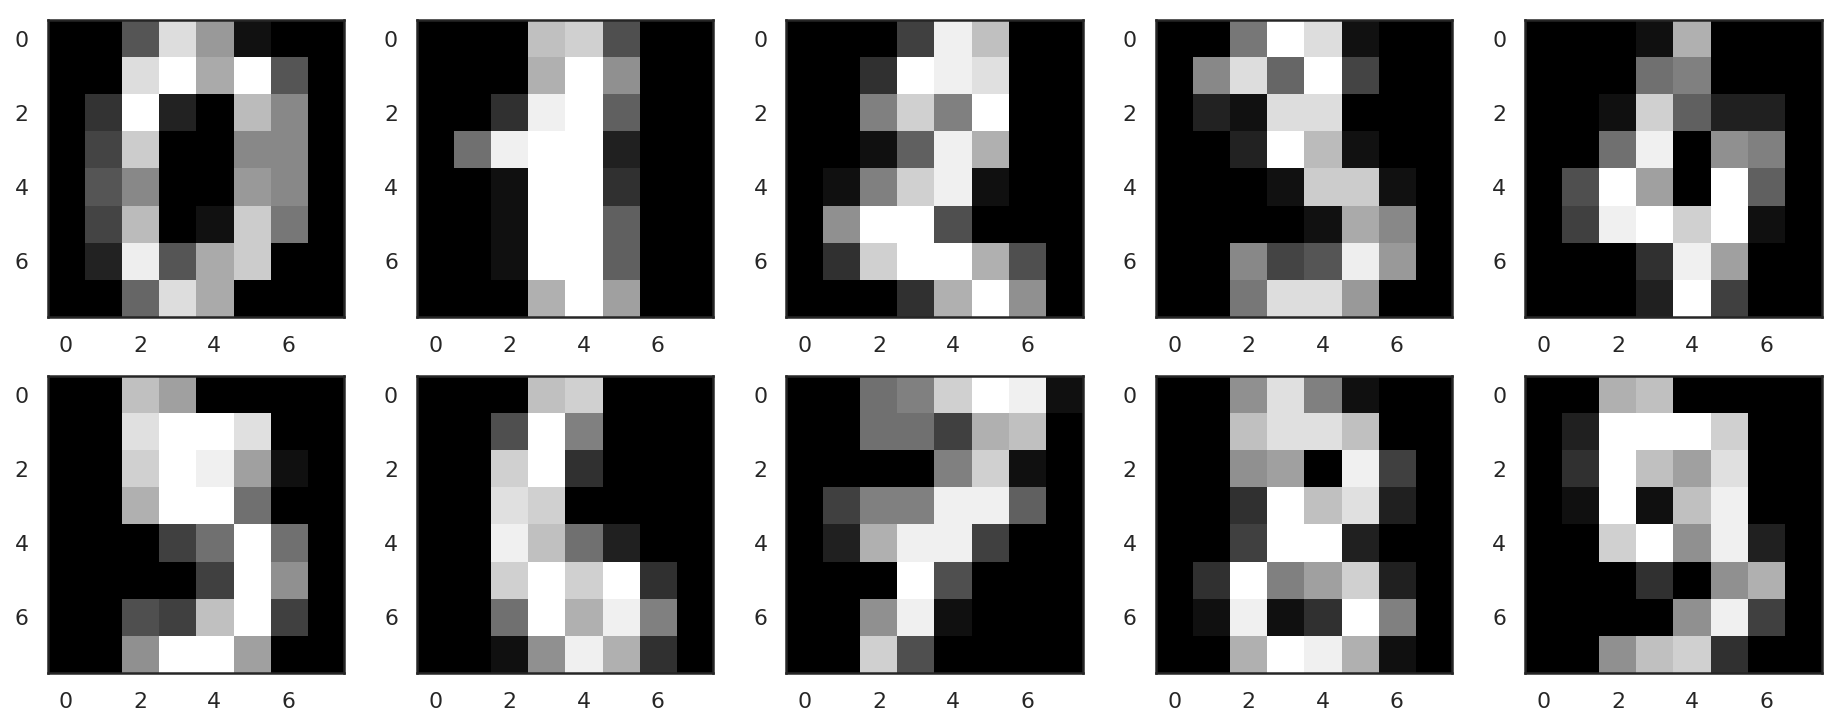

In [7]:
# f, axes = plt.subplots(5, 2, sharey=True, figsize=(16,6))
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i,:].reshape([8,8]), cmap='gray');

Our data has 64 dimensions, but we are going to reduce it to only 2 and see that, even with just 2 dimensions, we can clearly see that digits separate into clusters.

Projecting 64-dimensional data to 2D


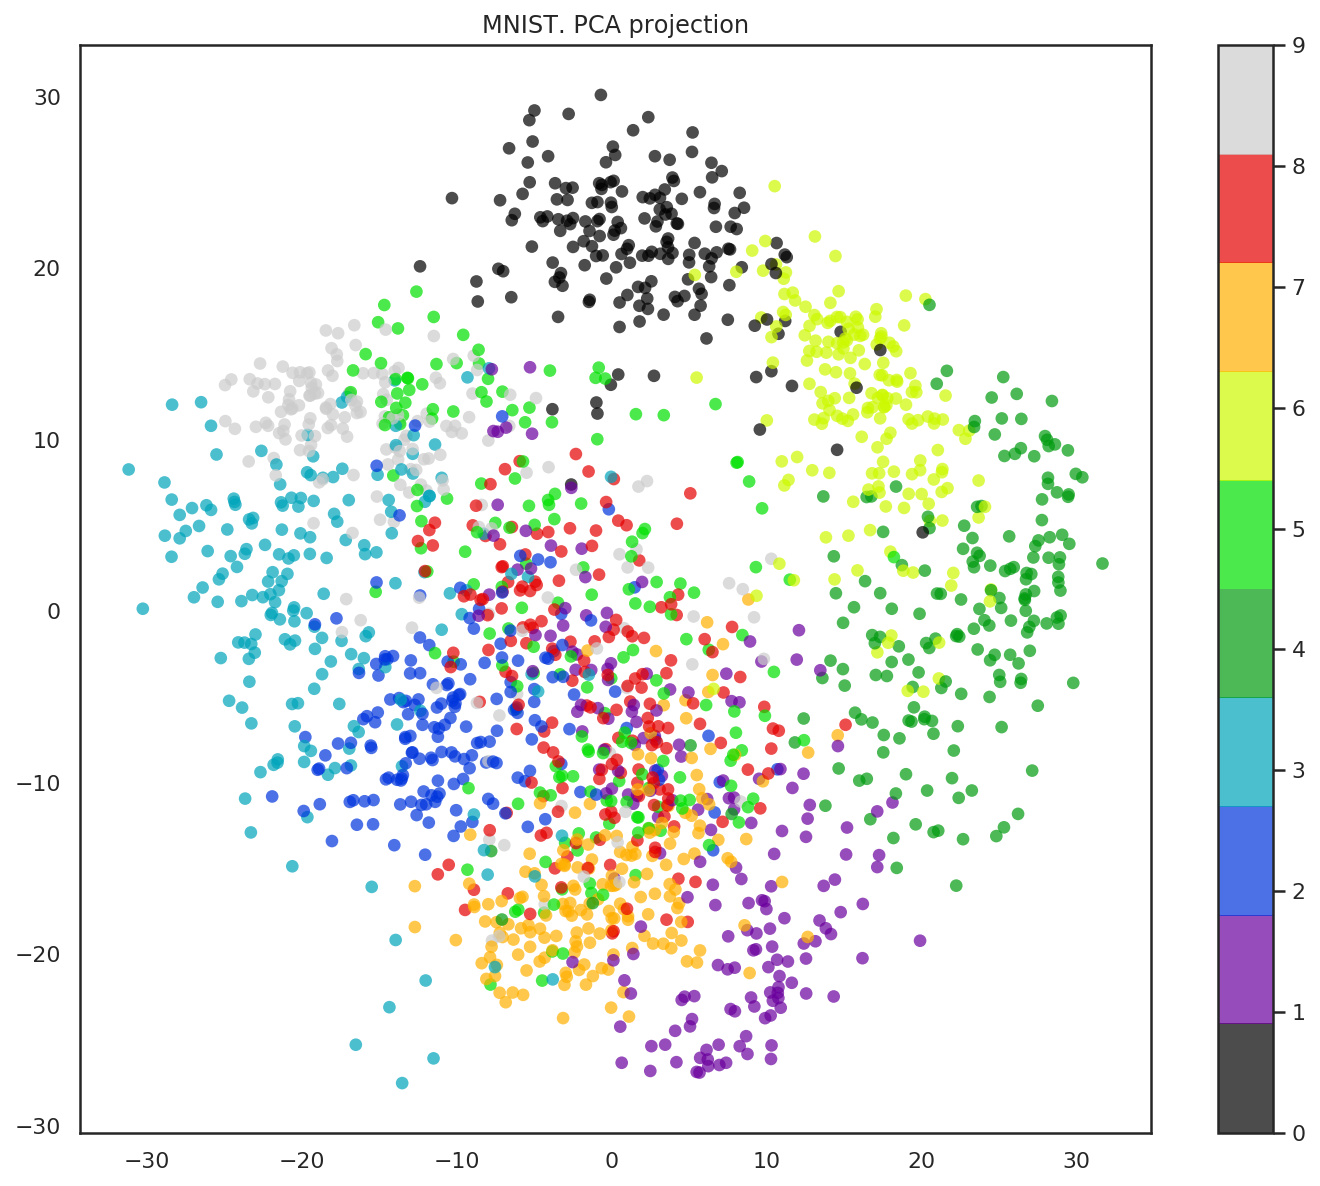

In [8]:
pca = decomposition.PCA(n_components=2)
X_reduced = pca.fit_transform(X)

print('Projecting %d-dimensional data to 2D' % X.shape[1])

plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. PCA projection');

Indeed, with t-SNE, the picture looks better since PCA has a linear constraint while t-SNE does not. However, even with such a small dataset, the t-SNE algorithm takes significantly more time to complete than PCA.


__T-SNE Explanation__:
T-distributed Stochastic Neighbor Embedding (t-SNE) is a machine learning technique used for data visualization and dimensionality reduction. It is particularly effective for visualizing high-dimensional data in lower-dimensional spaces (usually 2D or 3D) while preserving the local structure of the data as much as possible.

- **High-Dimensional to Low-Dimensional Mapping:** t-SNE takes high-dimensional data as input and maps it to a lower-dimensional space, typically 2D or 3D, where it can be visualized easily.

- **Preserving Local Structure:** Unlike some other dimensionality reduction techniques like PCA (Principal Component Analysis), which focus on preserving global structure, t-SNE emphasizes preserving local structure. It tries to keep similar data points close together in the lower-dimensional space, maintaining the local relationships between data points as much as possible.

- **Stochastic Neighbor Embedding:** t-SNE works by measuring pairwise similarities between data points in the high-dimensional space and in the low-dimensional space. It uses a probability distribution to represent the relationships between data points. The similarity between two data points in the high-dimensional space is represented by a conditional probability distribution, while the similarity between the corresponding points in the low-dimensional space is represented by another conditional probability distribution. The goal is to minimize the difference between these two distributions.

- **Gradient Descent Optimization:** t-SNE optimizes the lower-dimensional representation of data points using gradient descent. It minimizes the mismatch between the conditional probabilities of points in the high-dimensional space and their counterparts in the low-dimensional space. This optimization process iteratively adjusts the positions of data points in the lower-dimensional space until the best representation is achieved.

- **Visualization:** Once the optimization process is complete, t-SNE provides a 2D or 3D representation of the data that can be easily visualized. Data points that are similar in the high-dimensional space will be close together in the lower-dimensional space, allowing patterns and clusters in the data to be visually identified.

However, it's essential to note that t-SNE has its limitations. It can be computationally expensive for large datasets and might not always preserve global structure accurately. Therefore, it's often used as an exploratory tool in combination with other dimensionality reduction techniques and data analysis methods.


CPU times: user 14.1 s, sys: 11.5 ms, total: 14.1 s
Wall time: 14.1 s


Text(0.5, 1.0, 'MNIST. t-SNE projection')

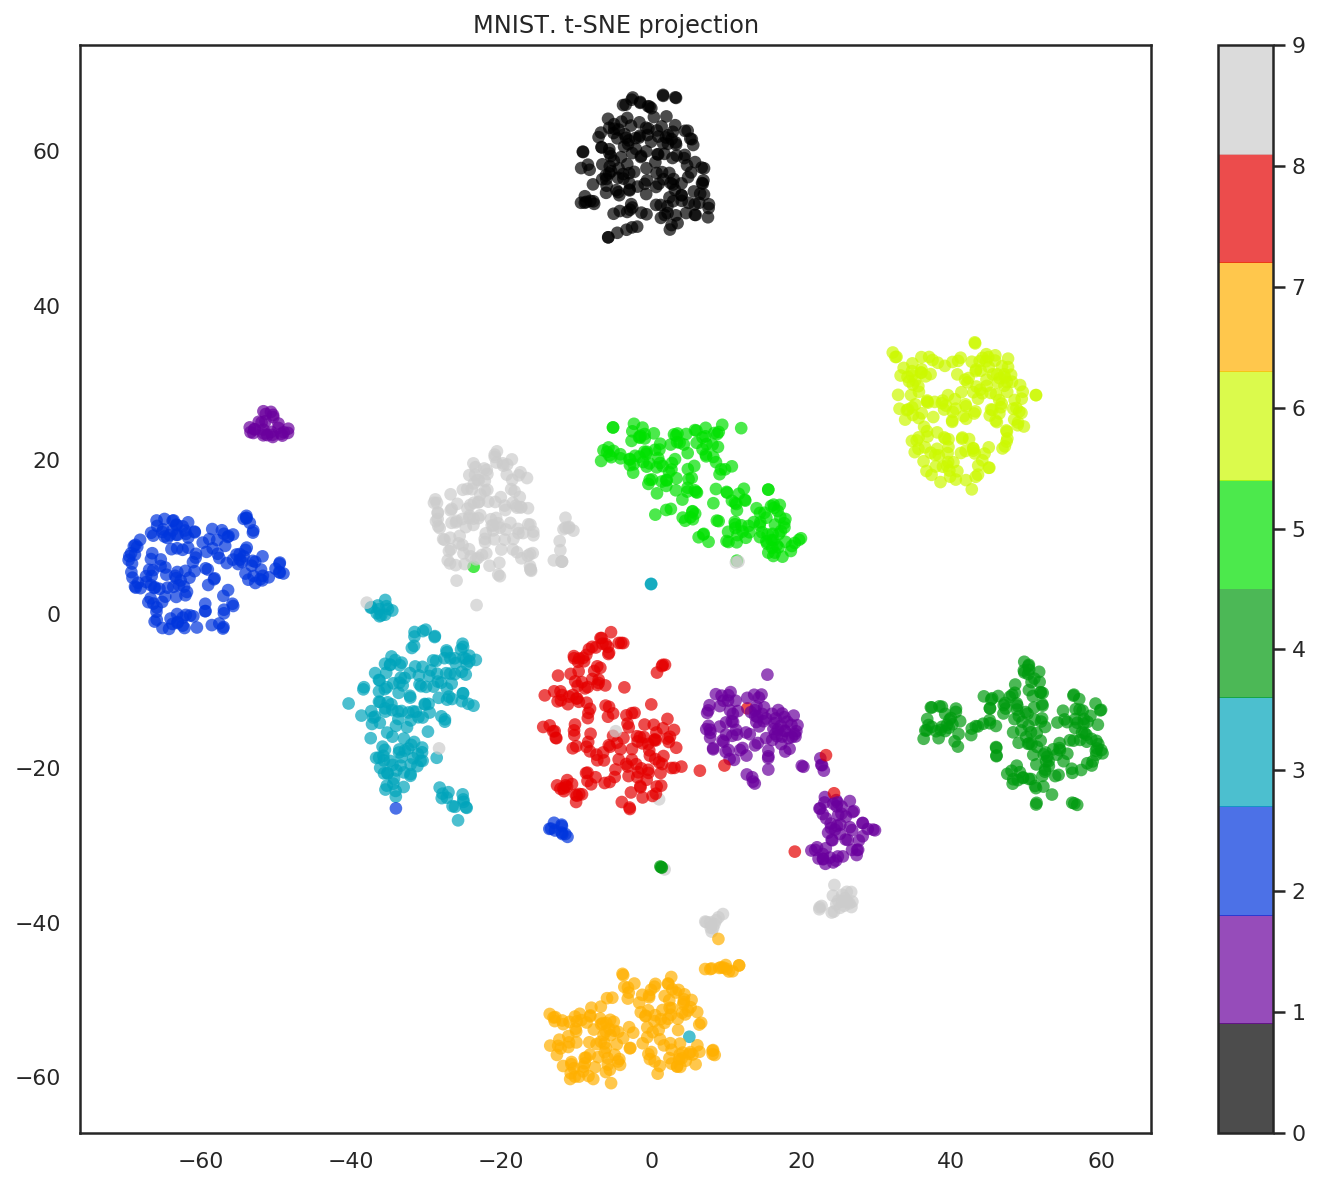

In [9]:
%%time

from sklearn.manifold import TSNE
tsne = TSNE(random_state=17)

X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(12,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. t-SNE projection');

In practice, we would choose the number of principal components such that we can explain 90% of the initial data dispersion (via the `explained_variance_ratio`). Here, that means retaining 21 principal components; therefore, we reduce the dimensionality from 64 features to 21.

According to the following code, selecting 21 component gives us at least 90% explanation.

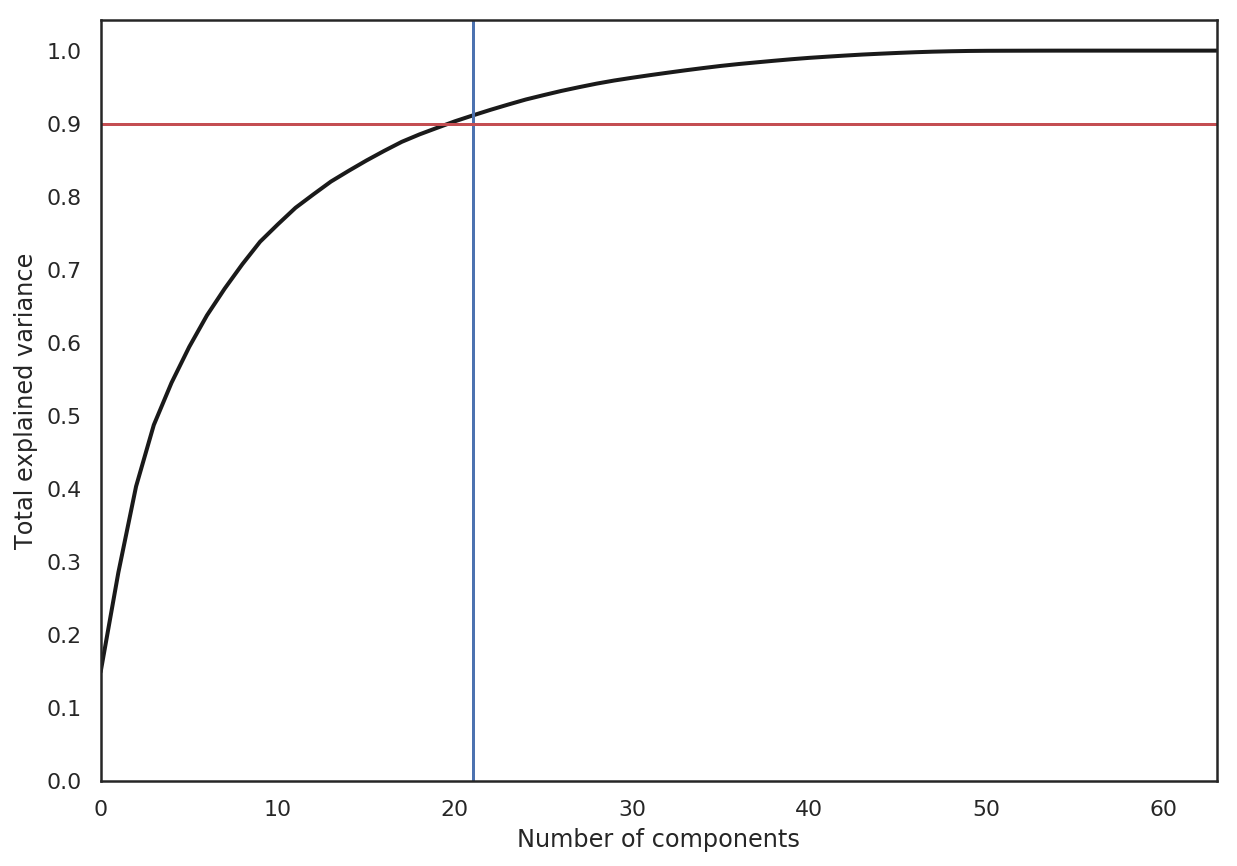

In [10]:
pca = decomposition.PCA().fit(X)

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 63)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(21, c='b')
plt.axhline(0.9, c='r')
plt.show();

## 3. Clustering

The main idea behind clustering is pretty straightforward. Basically, we say to ourselves, "I have these points here, and I can see that they organize into groups. It would be nice to describe these things more concretely, and, when a new point comes in, assign it to the correct group." This general idea encourages exploration and opens up a variety of algorithms for clustering.

<figure><img align="center" src="https://habrastorage.org/getpro/habr/post_images/8b9/ae5/586/8b9ae55861f22a2809e8b3a00ef815ad.png"><figcaption>*The examples of the outcomes from different algorithms from scikit-learn*</figcaption></figure>

The algorithms listed below do not cover all the clustering methods out there, but they are the most commonly used ones.

### K-means

K-means algorithm is the most popular and yet simplest of all the clustering algorithms. Here is how it works:
1. Select the number of clusters $k$ that you think is the optimal number.
2. Initialize $k$ points as "centroids" randomly within the space of our data.
3. Attribute each observation to its closest centroid.
4. Update the centroids to the center of all the attributed set of observations. 
5. Repeat steps 3 and 4 a fixed number of times or until all of the centroids are stable (i.e. no longer change in step 4).

This algorithm is easy to describe and visualize. Let's take a look.

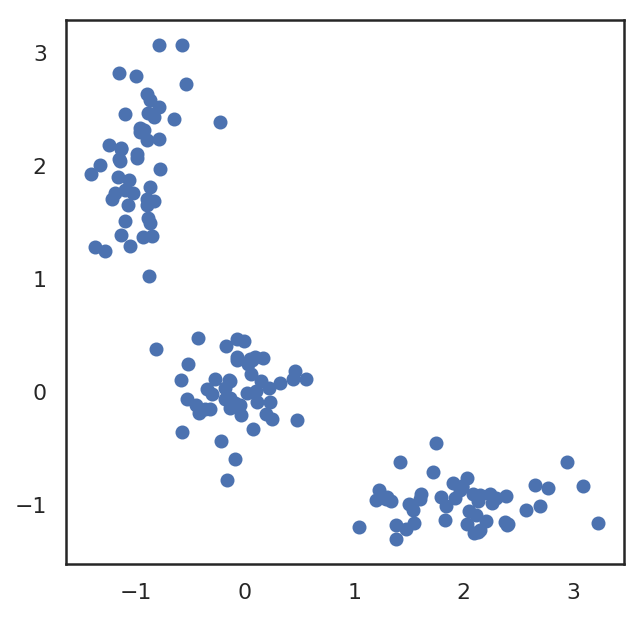

In [11]:
# Let's begin by allocation 3 cluster's points
X = np.zeros((150, 2))

np.random.seed(seed=42)
X[:50, 0] = np.random.normal(loc=0.0, scale=.3, size=50)
X[:50, 1] = np.random.normal(loc=0.0, scale=.3, size=50)

X[50:100, 0] = np.random.normal(loc=2.0, scale=.5, size=50)
X[50:100, 1] = np.random.normal(loc=-1.0, scale=.2, size=50)

X[100:150, 0] = np.random.normal(loc=-1.0, scale=.2, size=50)
X[100:150, 1] = np.random.normal(loc=2.0, scale=.5, size=50)

plt.figure(figsize=(5, 5))
plt.plot(X[:, 0], X[:, 1], 'bo');

In the below code:
- "cdist" is a function that calculates the distances between two sets of points efficiently.

In [12]:
# Scipy has function that takes 2 tuples and return
# calculated distance between them
from scipy.spatial.distance import cdist

# Randomly allocate the 3 centroids 
np.random.seed(seed=42)
centroids = np.random.normal(loc=0.0, scale=1., size=6)
centroids = centroids.reshape((3, 2)) ## Initializing 3 random centroids

cent_history = []
cent_history.append(centroids)

for i in range(3):
    # Calculating the distance from a point to a centroid
    distances = cdist(X, centroids)
    # Checking what's the closest centroid for the point
    labels = distances.argmin(axis=1)
    
    # Labeling the point according the point's distance
    centroids = centroids.copy()
    centroids[0, :] = np.mean(X[labels == 0, :], axis=0)
    centroids[1, :] = np.mean(X[labels == 1, :], axis=0)
    centroids[2, :] = np.mean(X[labels == 2, :], axis=0)
    
    cent_history.append(centroids)

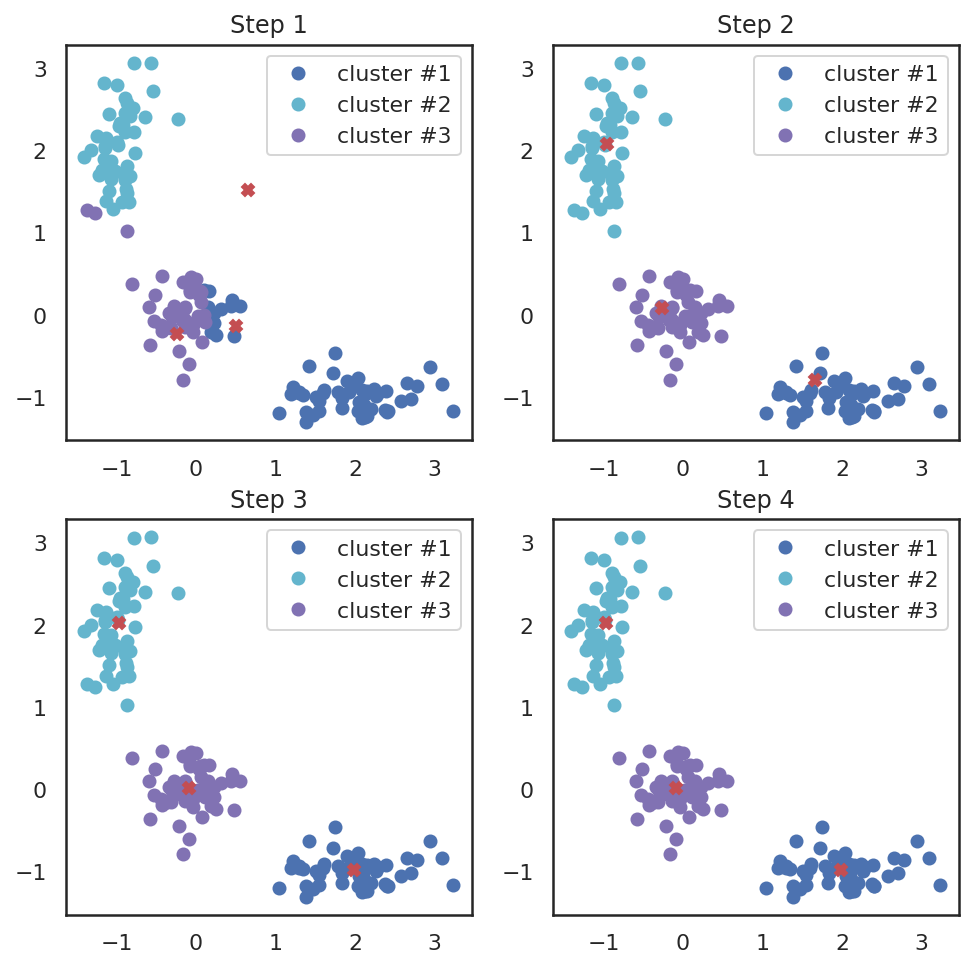

In [13]:
# Let's plot K-means
plt.figure(figsize=(8, 8))
for i in range(4):
    distances = cdist(X, cent_history[i])
    labels = distances.argmin(axis=1)
    
    plt.subplot(2, 2, i + 1)
    plt.plot(X[labels == 0, 0], X[labels == 0, 1], 'bo', label='cluster #1')
    plt.plot(X[labels == 1, 0], X[labels == 1, 1], 'co', label='cluster #2')
    plt.plot(X[labels == 2, 0], X[labels == 2, 1], 'mo', label='cluster #3')
    plt.plot(cent_history[i][:, 0], cent_history[i][:, 1], 'rX')
    plt.legend(loc=0)
    plt.title('Step {:}'.format(i + 1));

Here, we used Euclidean distance, but the algorithm will converge with any other metric. You can not only vary the number of steps or the convergence criteria but also the distance measure between the points and cluster centroids.

Another "feature" of this algorithm is its sensitivity to the initial positions of the cluster centroids. You can run the algorithm several times and then average all the centroid results. This means that, when we run the algorithm each time, we might get different resulsts due to the randomness.

## Choosing the number of clusters for K-means

In contrast to the supervised learning tasks such as classification and regression, clustering requires more effort to choose the optimization criterion. Usually, when working with k-means, we optimize the sum of squared distances between the observations and their centroids.

$$\Large J(C) = \sum_{k=1}^K\sum_{i~\in~C_k} ||x_i - \mu_k|| \rightarrow \min\limits_C,$$

where $C$ – is a set of clusters with power $K$, $\mu_k$ is a centroid of a cluster $C_k$.

This definition seems reasonable -- we want our observations to be as close to their centroids as possible. But, there is a problem -- the optimum is reached when the number of centroids is equal to the number of observations, so you would end up with every single observation as its own separate cluster.

In order to avoid that case, we should choose a number of clusters after which a function $J(C_k)$ is decreasing less rapidly. More formally,
$$\Large D(k) = \frac{|J(C_k) - J(C_{k+1})|}{|J(C_{k-1}) - J(C_k)|}  \rightarrow \min\limits_k $$

Let's look at an example.

In [14]:
from sklearn.cluster import KMeans

In [15]:
inertia = []
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))


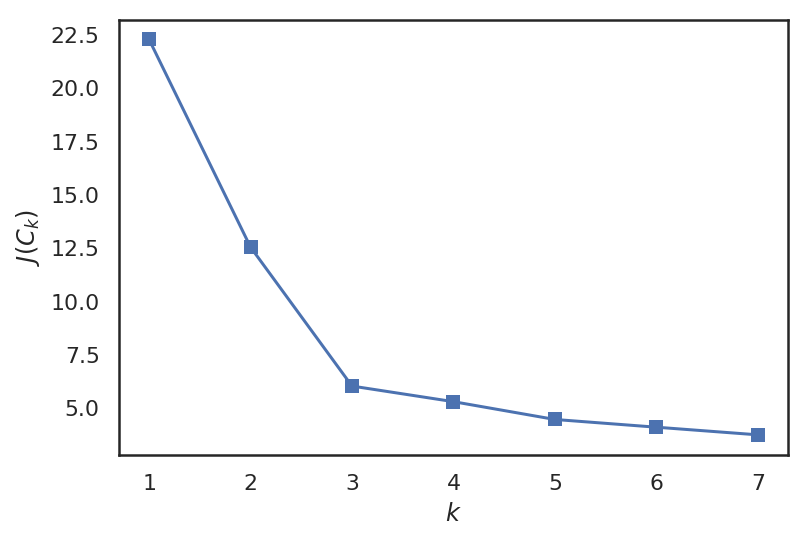

In [16]:
plt.plot(range(1, 8), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

We see that $J(C_k)$ decreases significantly until the number of clusters is 3 and then does not change as much anymore. This means that the optimal number of clusters is 3. 

This technique is known as the **elbow technique**.

#### Issues

Inherently, K-means is NP-hard. For $d$ dimensions, $k$ clusters, and $n$ observations, we will find a solution in $O(n^{d k+1})$ in time. There are some heuristics to deal with this; an example is MiniBatch K-means, which takes portions (batches) of data instead of fitting the whole dataset and then moves centroids by taking the average of the previous steps. Compare the implementation of K-means and MiniBatch K-means in the [sckit-learn documentation](http://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html).

The [implemetation](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) of the algorithm using `scikit-learn` has its benefits such as the possibility to state the number of initializations with the `n_init` function parameter, which enables us to identify more robust centroids. Moreover, these runs can be done in parallel to decrease the computation time.

## Affinity Propagation

**Affinity propagation** is another example of a *clustering algorithm*. As opposed to K-means, this approach does not require us to set the number of clusters beforehand. The main idea here is that we would like to cluster our data based on the similarity of the observations (or how they "correspond" to each other).

Let's define a similarity metric such that $s(x_i, x_j) > s(x_i, x_k)$ if an observation $x_i$ is more similar to observation $x_j$ and less similar to observation $x_k$. A simple example of such a similarity metric is a negative square of distance $s(x_i, x_j) = - ||x_i - x_j||^{2}$.


Now, let's describe **"correspondence"** by making two zero matrices. One of them, $r_{i,k}$, determines how well the $k$th observation is as a "role model" for the $i$th observation with respect to all other possible "role models". Another matrix, $a_{i,k}$ determines how appropriate it would be for $i$th observation to take the $k$th observation as a "role model". This may sound confusing, but it becomes more understandable with some hands-on practice.

The matrices are updated sequentially with the following rules:

$$r_{i,k} \leftarrow s_(x_i, x_k) - \max_{k' \neq k} \left\{ a_{i,k'} + s(x_i, x_k') \right\}$$

$$a_{i,k} \leftarrow \min \left( 0, r_{k,k} + \sum_{i' \not\in \{i,k\}} \max(0, r_{i',k}) \right), \ \ \  i \neq k$$

$$a_{k,k} \leftarrow \sum_{i' \neq k} \max(0, r_{i',k})$$

### An example of Affinity Propagation
Here's a complete example of how to use Affinity Propagation using Python's scikit-learn library:

```python
# Import necessary libraries
from sklearn.cluster import AffinityPropagation
from sklearn import datasets
import numpy as np

# Load a sample dataset (for demonstration purposes, we'll use the Iris dataset)
iris = datasets.load_iris()
X = iris.data

# Perform Affinity Propagation clustering
# Here, we set the preference parameter to -50, which influences the number of exemplars
# You may need to adjust this parameter based on your dataset
af = AffinityPropagation(preference=-50).fit(X)

# Extract cluster centers (exemplars) and labels
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters:', n_clusters_)
print('Cluster centers (exemplars):')
print(X[cluster_centers_indices])

# Print cluster assignments for each data point
for i in range(len(X)):
    print("Data point:", X[i], "Cluster:", labels[i])
```

In this example:

- We import the necessary libraries: `AffinityPropagation` from scikit-learn for Affinity Propagation clustering, `datasets` for loading sample datasets, and `numpy` for numerical operations.

- We load the Iris dataset from scikit-learn's datasets module. You can replace it with your dataset.

- We perform Affinity Propagation clustering using `AffinityPropagation().fit(X)`. We set the preference parameter to influence the number of exemplars. This parameter is crucial and may require tuning based on your dataset and the desired number of clusters.

- We extract the cluster centers (exemplars) using `cluster_centers_indices` and get the labels for each data point using `labels_`.

- We print out the estimated number of clusters, the cluster centers (exemplars), and the cluster assignments for each data point.

Affinity Propagation is quite flexible and powerful, but it may require careful tuning of its parameters to achieve the desired clustering results, especially the preference parameter. Additionally, it may not be suitable for very large datasets due to its quadratic time complexity.

## Spectral clustering

**Spectral clustering** combines some of the approaches described above to create a stronger clustering method.

First of all, this algorithm requires us to define the similarity matrix for observations called the **adjacency matrix**. This can be done in a similar fashion as in the Affinity Propagation algorithm: $A_{i, j} = - ||x_i - x_j||^{2}$. This matrix describes a full graph with the observations as vertices and the estimated similarity value between a pair of observations as edge weights for that pair of vertices. For the metric defined above and two-dimensional observations, this is pretty intuitive - two observations are similar if the edge between them is shorter. 
We'd like to split up the graph into two subgraphs in such a way that each observation in each subgraph would be similar to another observation in that subgraph. Formally, this is a Normalized cuts problem; for more details, we recommend reading [this paper](http://people.eecs.berkeley.edu/~malik/papers/SM-ncut.pdf).

### An example of Spectral Clustring
Spectral Clustering uses the eigenvectors of a similarity matrix to reduce the dimensionality of the data before clustering in a lower-dimensional space. Here's a complete example of how to use Spectral Clustering using Python's scikit-learn library:

```python
# Import necessary libraries
from sklearn.cluster import SpectralClustering
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load a sample dataset (for demonstration purposes, we'll use the Iris dataset)
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform Spectral Clustering
# We set the number of clusters to 3, which matches the number of classes in the Iris dataset
# You may need to adjust this parameter based on your dataset
spectral_clustering = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', random_state=42)
y_pred = spectral_clustering.fit_predict(X_scaled)

# Evaluate clustering performance (for demonstration purposes, since we have ground truth labels)
accuracy = np.mean(y_pred == y)
print("Clustering Accuracy:", accuracy)

# Print cluster assignments
print("Cluster assignments:")
for i in range(len(X)):
    print("Data point:", X[i], "Cluster:", y_pred[i])
```

In this example:

- We import the necessary libraries: `SpectralClustering` from scikit-learn for Spectral Clustering, `datasets` for loading sample datasets, and `StandardScaler` for feature scaling.

- We load the Iris dataset from scikit-learn's datasets module. You can replace it with your dataset.

- We standardize the features using `StandardScaler` to ensure that each feature has a mean of 0 and a standard deviation of 1. This step is important for Spectral Clustering.

- We perform Spectral Clustering using `SpectralClustering().fit_predict(X_scaled)`. We set the number of clusters to 3, which matches the number of classes in the Iris dataset. You may need to adjust this parameter based on your dataset.

- We evaluate clustering performance by comparing the cluster assignments (`y_pred`) with the ground truth labels (`y`) using accuracy.

- We print out the cluster assignments for each data point.

Spectral Clustering is effective for finding clusters in non-convex datasets and datasets with complex geometric structures. However, it may require parameter tuning, such as choosing the number of clusters and the type of affinity matrix, to achieve good clustering results.

## Agglomerative clustering
The following algorithm is the simplest and easiest to understand among all the the clustering algorithms without a fixed number of clusters.


The algorithm is fairly simple:
1. We start by assigning each observation to its own cluster
2. Then sort the pairwise distances between the centers of clusters in descending order
3. Take the nearest two neigbor clusters and merge them together, and recompute the centers
4. Repeat steps 2 and 3 until all the data is merged into one cluster

The process of searching for the nearest cluster can be conducted with different methods of bounding the observations:
1. Single linkage 
$d(C_i, C_j) = min_{x_i \in C_i, x_j \in C_j} ||x_i - x_j||$
2. Complete linkage 
$d(C_i, C_j) = max_{x_i \in C_i, x_j \in C_j} ||x_i - x_j||$
3. Average linkage 
$d(C_i, C_j) = \frac{1}{n_i n_j} \sum_{x_i \in C_i} \sum_{x_j \in C_j} ||x_i - x_j||$
4. Centroid linkage 
$d(C_i, C_j) = ||\mu_i - \mu_j||$

The 3rd one is the most effective in computation time since it does not require recomputing the distances every time the clusters are merged.

The results can be visualized as a beautiful cluster tree (dendogram) to help recognize the moment the algorithm should be stopped to get optimal results. There are plenty of Python tools to build these dendograms for agglomerative clustering.

Let's consider an example with the clusters we got from K-means:

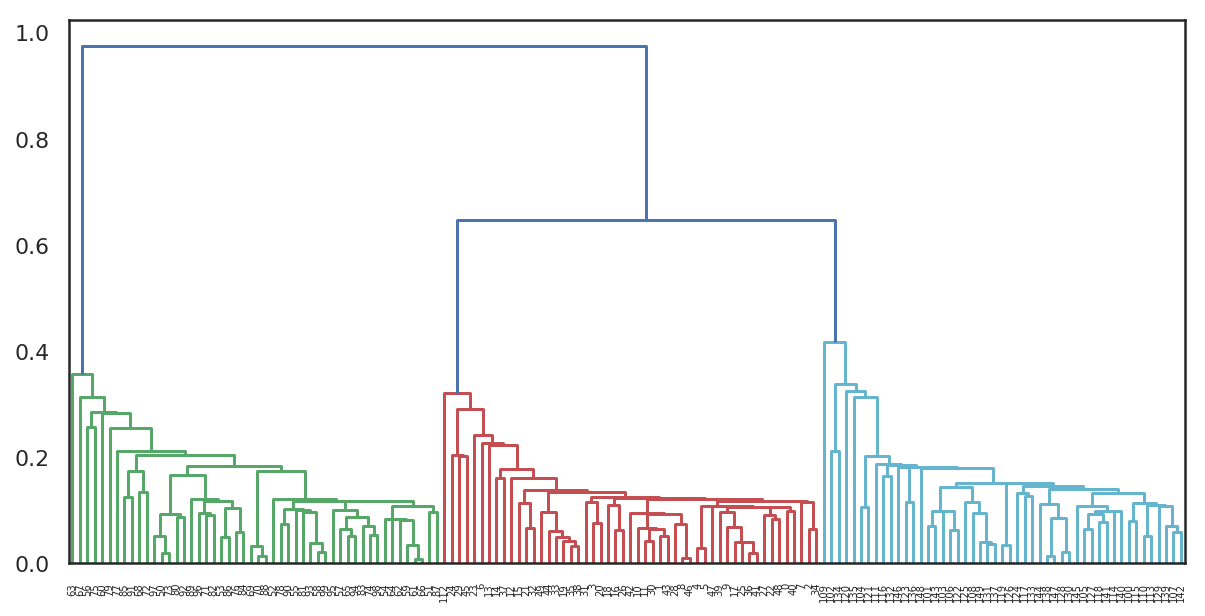

In [17]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

X = np.zeros((150, 2))

np.random.seed(seed=42)
X[:50, 0] = np.random.normal(loc=0.0, scale=.3, size=50)
X[:50, 1] = np.random.normal(loc=0.0, scale=.3, size=50)

X[50:100, 0] = np.random.normal(loc=2.0, scale=.5, size=50)
X[50:100, 1] = np.random.normal(loc=-1.0, scale=.2, size=50)

X[100:150, 0] = np.random.normal(loc=-1.0, scale=.2, size=50)
X[100:150, 1] = np.random.normal(loc=2.0, scale=.5, size=50)

# pdist will calculate the upper triangle of the pairwise distance matrix
distance_mat = pdist(X) 
# linkage — is an implementation if agglomerative algorithm
Z = hierarchy.linkage(distance_mat, 'single')
plt.figure(figsize=(10, 5))
dn = hierarchy.dendrogram(Z, color_threshold=0.5)

## Accuracy metrics

As opposed to classfication, it is difficult to assess the quality of results from clustering. Here, a metric cannot depend on the labels but only on the goodness of split. Secondly, we do not usually have true labels of the observations when we use clustering.

There are *internal* and *external* goodness metrics. External metrics use the information about the known true split while internal metrics do not use any external information and assess the goodness of clusters based only on the initial data. The optimal number of clusters is usually defined with respect to some internal metrics. 

All the metrics described below are implemented in `sklearn.metrics`.

**Adjusted Rand Index (ARI)**

Here, we assume that the true labels of objects are known. This metric does not depend on the labels' values but on the data cluster split. Let $N$ be the number of observations in a sample. Let $a$ to be the number of observation pairs with the same labels and located in the same cluster, and let $b$ to be the number of observations with different labels and located in different clusters. The Rand Index can be calculated using the following formula: 

$$\Large \text{RI} = \frac{2(a + b)}{n(n-1)}.$$ 

In other words, it evaluates a share of observations for which these splits (initial and clustering result) are consistent. The Rand Index (RI) evaluates the similarity of the two splits of the same sample. In order for this index to be close to zero for any clustering outcomes with any $n$ and number of clusters, it is essential to scale it, hence the Adjusted Rand Index: 

$$\Large \text{ARI} = \frac{\text{RI} - E[\text{RI}]}{\max(\text{RI}) - E[\text{RI}]}.$$

This metric is symmetric and does not depend in the label permutation. Therefore, this index is a measure of distances between different sample splits. $\text{ARI}$ takes on values in the $[-1, 1]$ range. Negative values indicate the independence of splits, and positive values indicate that these splits are consistent (they match $\text{ARI} = 1$).

**Adjusted Mutual Information (AMI)**

This metric is similar to $\text{ARI}$. It is also symmetric and does not depend on the labels' values and permutation. It is defined by the [entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory) function and interprets a sample split as a discrete distribution (likelihood of assigning to a cluster is equal to the percent of objects in it). The $MI$ index is defined as the [mutual information](https://en.wikipedia.org/wiki/Mutual_information) for two distributions, corresponding to the sample split into clusters. Intuitively, the mutual information measures the share of information common for both clustering splits i.e. how information about one of them decreases the uncertainty of the other one.

Similarly to the $\text{ARI}$, the $\text{AMI}$ is defined. This allows us to get rid of the $MI$ index's increase with the number of clusters. The $\text{AMI}$ lies in the $[0, 1]$ range. Values close to zero mean the splits are independent, and those close to 1 mean they are similar (with complete match at $\text{AMI} = 1$).

**Homogeneity, completeness, V-measure**

Formally, these metrics are also defined based on the entropy function and the conditional entropy function, interpreting the sample splits as discrete distributions: 

$$\Large h = 1 - \frac{H(C\mid K)}{H(C)}, c = 1 - \frac{H(K\mid C)}{H(K)},$$

where $K$ is a clustering result and $C$ is the initial split. Therefore, $h$ evaluates whether each cluster is composed of same class objects, and $c$ measures how well the same class objects fit the clusters. These metrics are not symmetric. Both lie in the $[0, 1]$ range, and values closer to 1 indicate more accurate clustering results. These metrics' values are not scaled as the $\text{ARI}$ or $\text{AMI}$ metrics are and thus depend on the number of clusters. A random clustering result will not have metrics' values closer to zero when the number of clusters is big enough and the number of objects is small. In such a case, it would be more reasonable to use $\text{ARI}$. However, with a large number of observations (more than 100) and the number of clusters less than 10, this issue is less critical and can be ignored.

$V$-measure is a combination of $h$, and $c$ and is their harmonic mean:
$$\Large v = 2\frac{hc}{h+c}.$$
It is symmetric and measures how consistent two clustering results are.

**Silhouette**

In contrast to the metrics described above, this coefficient does not imply the knowledge about the true labels of the objects. It lets us estimate the quality of the clustering using only the initial, unlabeled sample and the clustering result. To start with, for each observation, the silhouette coefficient is computed. Let $a$ be the mean of the distance between an object and other objects within one cluster and $b$ be the mean distance from an object to an object from the nearest cluster (different from the one the object belongs to). Then the silhouette measure for this object is 

$$\Large s = \frac{b - a}{\max(a, b)}.$$

The silhouette of a sample is a mean value of silhouette values from this sample. Therefore, the silhouette distance shows to which extent the distance between the objects of the same class differ from the mean distance between the objects from different clusters. This coefficient takes values in the $[-1, 1]$ range. Values close to -1 correspond to bad clustering results while values closer to 1 correspond to dense, well-defined clusters. Therefore, the higher the silhouette value is, the better the results from clustering.

With the help of silhouette, we can identify the optimal number of clusters $k$ (if we don't know it already from the data) by taking the number of clusters that maximizes the silhouette coefficient.

To conclude, let's take a look at how these metrics perform with the MNIST handwritten numbers dataset:

In [18]:
from sklearn import metrics
from sklearn import datasets
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, SpectralClustering


data = datasets.load_digits()
X, y = data.data, data.target

algorithms = []
algorithms.append(KMeans(n_clusters=10, random_state=1))
algorithms.append(AffinityPropagation())
algorithms.append(SpectralClustering(n_clusters=10, random_state=1,
                                     affinity='nearest_neighbors'))
algorithms.append(AgglomerativeClustering(n_clusters=10))

data = []
for algo in algorithms:
    algo.fit(X)
    data.append(({
        'ARI': metrics.adjusted_rand_score(y, algo.labels_),
        'AMI': metrics.adjusted_mutual_info_score(y, algo.labels_,
                                                 average_method='arithmetic'),
        'Homogenity': metrics.homogeneity_score(y, algo.labels_),
        'Completeness': metrics.completeness_score(y, algo.labels_),
        'V-measure': metrics.v_measure_score(y, algo.labels_),
        'Silhouette': metrics.silhouette_score(X, algo.labels_)}))

results = pd.DataFrame(data=data, columns=['ARI', 'AMI', 'Homogenity',
                                           'Completeness', 'V-measure', 
                                           'Silhouette'],
                       index=['K-means', 'Affinity', 
                              'Spectral', 'Agglomerative'])

results

,ARI,AMI,Homogenity,Completeness,V-measure,Silhouette
K-means,0.662295,0.736567,0.735448,0.742972,0.739191,0.182097
Affinity,0.175174,0.612460,0.958907,0.486901,0.645857,0.115197
Spectral,0.756461,0.852040,0.831691,0.876614,0.853562,0.182729
Agglomerative,0.794003,0.866832,0.857513,0.879096,0.868170,0.178497


Short explnation of Metrics:
- **ARI (Adjusted Rand Index):** ARI measures the similarity between two clusterings, considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.
- **AMI (Adjusted Mutual Information):** AMI measures the agreement between two clusterings, accounting for chance. It's based on the mutual information between the predicted and true clusterings.
- **Homogeneity:** Homogeneity measures whether each cluster contains only members of a single class. It quantifies the degree to which clusters contain only data points that are members of a single class.
- **Completeness:** Completeness measures whether all members of a given class are assigned to the same cluster. It quantifies the degree to which all data points that are members of a given class are also elements of the same cluster.
- **V-measure:** V-measure is the harmonic mean of homogeneity and completeness. It provides a single, combined score for the quality of clustering.
- **Silhouette:** Silhouette coefficient measures how similar an object is to its own cluster compared to other clusters. The value ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

Based on the results:
- **K-means:** Performs well in ARI, AMI, Homogeneity, Completeness, and V-measure metrics but has the lowest Silhouette score.
- **Affinity Propagation:** Has relatively low scores across most metrics, indicating poorer performance compared to the others.
- **Spectral Clustering:** Performs well across all metrics, especially in ARI, AMI, and V-measure.
- **Agglomerative Clustering:** Performs similarly to Spectral Clustering, with high scores across most metrics.

## 4. Demo assignment

To practice with PCA and clustering, you can complete [this assignment](https://www.kaggle.com/kashnitsky/a7-demo-unsupervised-learning) where you'll be analyzing data from accelerometers and gyros of Samsung Galaxy S3 mobile phones. The assignment is just for you to practice, and goes with [solution](https://www.kaggle.com/kashnitsky/a7-demo-unsupervised-learning-solution).

## 5. Useful resources
- Medium ["story"](https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-7-unsupervised-learning-pca-and-clustering-db7879568417) based on this notebook
- Main course [site](https://mlcourse.ai), [course repo](https://github.com/Yorko/mlcourse.ai), and YouTube [channel](https://www.youtube.com/watch?v=QKTuw4PNOsU&list=PLVlY_7IJCMJeRfZ68eVfEcu-UcN9BbwiX)
- Course materials as a [Kaggle Dataset](https://www.kaggle.com/kashnitsky/mlcourse)
- Overview of clustering methods in the [scikit-learn doc](http://scikit-learn.org/stable/modules/clustering.html).
- [Q&A](http://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues) for PCA with examples
- [Notebook](https://github.com/diefimov/MTH594_MachineLearning/blob/master/ipython/Lecture10.ipynb) on k-means and the EM-algorithm



Refrence, Source and main Author: 
- [Sergey Korolev](https://www.linkedin.com/in/sokorolev/). Translated and edited by [Egor Polusmak](https://www.linkedin.com/in/egor-polusmak/), [Anastasia Manokhina](https://www.linkedin.com/in/anastasiamanokhina/), [Anna Golovchenko](https://www.linkedin.com/in/anna-golovchenko-b0ba5a112/), [Eugene Mashkin](https://www.linkedin.com/in/eugene-mashkin-88490883/), and [Yuanyuan Pao](https://www.linkedin.com/in/yuanyuanpao/). This material is subject to the terms and conditions of the license [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Free use is permitted for any non-comercial purpose.
- [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course
    
__The notebook is edited by me for self understanding and as self note. I have added some explanation in some parts which were a bit ambiguous__